In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from tests.leandro.tools import *
from tests.leandro.plots import *

import numpy as np
import pandas as pd
from IPython.display import display
from tabulate import tabulate

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist, squareform

from pylab import rcParams
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering
import sklearn.metrics as sm

In [3]:
np.set_printoptions(precision=4, suppress=True)
plt.figure(figsize=(10, 3))
%matplotlib inline
plt.style.use('seaborn-whitegrid')

/tmp/ipykernel_9639/2937752703.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


<Figure size 1000x300 with 0 Axes>

In [4]:
# Real data
dataset = get_real_data('/home/lrvnc/Projects/worm-graph/conf/dataset.yaml')
oneWorm, calcium_data, time_vector = get_one_worm_data(dataset)


config:
	 dataset:
  name: Flavell2023


Chosen dataset(s): ['Flavell2023']
Num. worms: 50

Worm ID: worm28


# Hierarchically neuron clustering
---

In [5]:
oneWorm.keys()

dict_keys(['dataset', 'smooth_method', 'worm', 'calcium_data', 'smooth_calcium_data', 'residual_calcium', 'smooth_residual_calcium', 'max_timesteps', 'time_in_seconds', 'dt', 'num_neurons', 'num_named_neurons', 'num_unknown_neurons', 'named_neurons_mask', 'unknown_neurons_mask', 'neurons_mask', 'slot_to_named_neuron', 'named_neuron_to_slot', 'slot_to_unknown_neuron', 'unknown_neuron_to_slot', 'slot_to_neuron', 'neuron_to_slot'])

In [6]:
X = oneWorm['smooth_calcium_data'] # (time, all neurons)
X = X[:, oneWorm['named_neurons_mask']]  # (time, named and acive neurons)
print("X.shape:", X.shape)

X.shape: torch.Size([9620, 73])


In [7]:
R = correlation_matrix(X)
R = (R + R.T) / 2  # Make it symmetric (just in case) -> numerical error
print("Correlation matrix shape:", R.shape)
D = 1 - R # Distance matrix
np.fill_diagonal(D, 0) # Make diagonal 0 (just in case)

Correlation matrix shape: (73, 73)


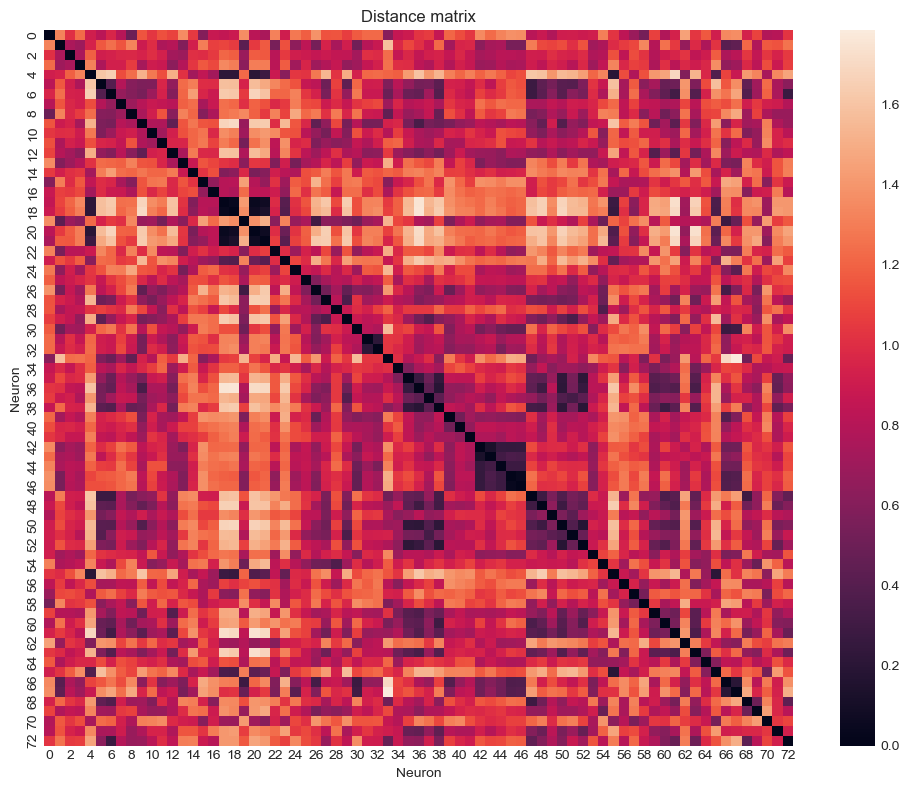

In [8]:
plotHeatmap(D, title="Distance matrix", xlabel="Neuron", ylabel="Neuron")

In [9]:
# The linkage function takes a condensed distance matrix, which is a flat array containing the upper triangular of the distance matrix. 
# We use squareform function to convert the matrix form to the condensed form.
condensed_D = squareform(D)
Z = linkage(condensed_D, method='complete')

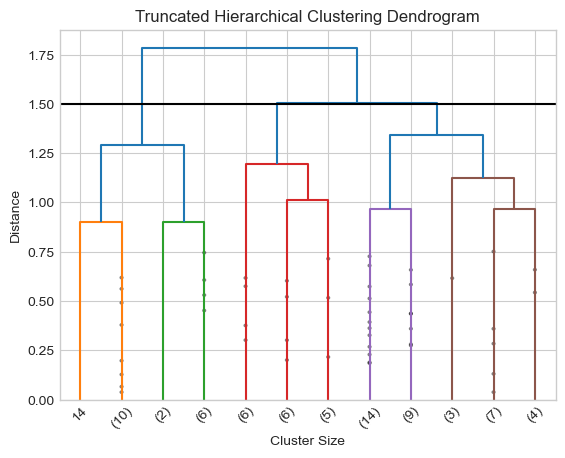

In [10]:
dendrogram(Z, truncate_mode='lastp', p=12, leaf_rotation=45., leaf_font_size=10., show_contracted=True)
plt.title('Truncated Hierarchical Clustering Dendrogram')
plt.xlabel('Cluster Size')
plt.ylabel('Distance')
plt.axhline(y=1.5, c='k')
plt.show()

In [11]:
# Now that we know how many clusters we want, we can cut the dendrogram at the desired number of clusters, and the cut_tree function will return a flat clustering.
distance = 1.5
cluster_labels = fcluster(Z, distance, criterion='distance')
print("Clusters:", cluster_labels)

Clusters: [1 2 3 3 1 3 3 1 1 3 3 2 3 3 1 1 1 1 1 2 1 1 2 1 3 3 2 3 2 3 2 2 2 1 3 3 3
 3 3 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 2 1 1 1 1 3 3 3 2 3 3 1 2 2 3 2 1 3 3]


In [12]:
# We can also cut the dendrogram at a given number of clusters, and the cut_tree function will return a flat clustering.
k = 6
cluster_labels = fcluster(Z, k, criterion='maxclust')
print("Clusters:", cluster_labels)

Clusters: [2 4 6 6 1 5 5 2 2 5 5 3 5 6 1 2 2 1 1 3 1 1 4 1 6 6 3 5 3 5 4 4 4 2 6 5 5
 5 5 4 4 4 6 6 6 6 6 5 5 6 5 5 5 6 3 1 2 1 2 5 5 5 4 5 6 1 4 4 5 3 1 5 5]


In [13]:
named_neurons_mask = oneWorm['named_neurons_mask']
len(oneWorm['slot_to_named_neuron'])
original_neuron_labels = [label for idx, label in oneWorm['slot_to_named_neuron'].items()]
original_neuron_labels = np.array(original_neuron_labels)

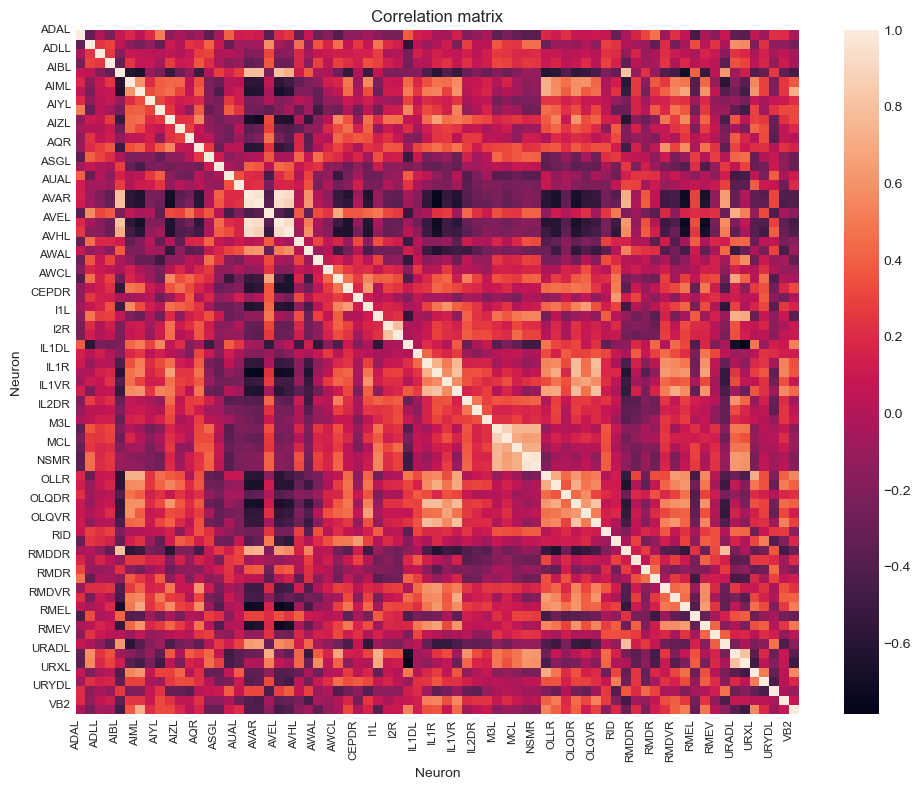

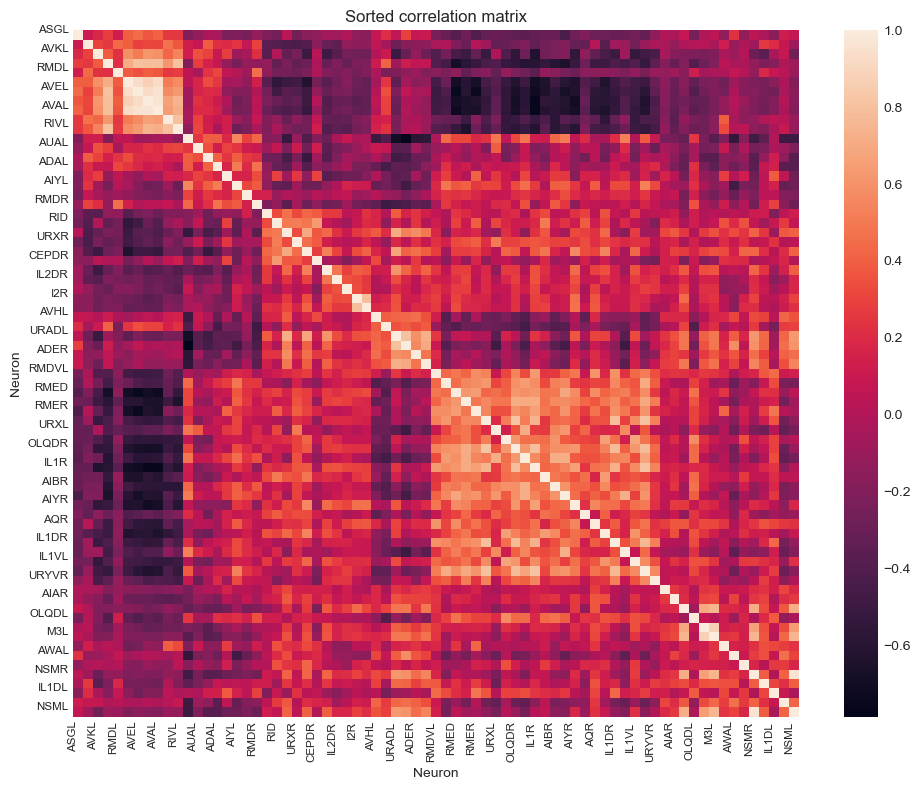

In [14]:
# Now we can sort the correlation matrix according to the cluster labels, and plot the correlation matrix again.
sorted_R = R[:, np.argsort(cluster_labels)]
sorted_R = sorted_R[np.argsort(cluster_labels), :]
sorted_neuron_labels = original_neuron_labels[np.argsort(cluster_labels)]
sorted_clusters = cluster_labels[np.argsort(cluster_labels)]

# Plot
plotHeatmap(R, title="Correlation matrix", xlabel="Neuron", ylabel="Neuron", xticks=original_neuron_labels, yticks=original_neuron_labels, xtick_skip=2, ytick_skip=2)
plotHeatmap(sorted_R, title="Sorted correlation matrix", xlabel="Neuron", ylabel="Neuron", xticks=sorted_neuron_labels, yticks=sorted_neuron_labels, xtick_skip=2, ytick_skip=2)

In [15]:
import json
# load json file form /home/lrvnc/Projects/worm-graph/tests/leandro/data/neuron_clusters.json
with open('/home/lrvnc/Projects/worm-graph/tests/leandro/data/neuron_clusters.json') as f:
    neuron_classification = json.load(f)

In [16]:
neuron_classification

{'ADAL': ['interneuron'],
 'ADAR': ['interneuron'],
 'ADEL': ['sensory'],
 'ADER': ['sensory'],
 'ADFL': ['sensory'],
 'ADFR': ['sensory'],
 'ADLL': ['sensory'],
 'ADLR': ['sensory'],
 'AFDL': ['sensory'],
 'AFDR': ['sensory'],
 'AIAL': ['interneuron'],
 'AIAR': ['interneuron'],
 'AIBL': ['interneuron'],
 'AIBR': ['interneuron'],
 'AIML': ['interneuron'],
 'AIMR': ['interneuron'],
 'AINL': ['interneuron'],
 'AINR': ['interneuron'],
 'AIYL': ['interneuron'],
 'AIYR': ['interneuron'],
 'AIZL': ['interneuron'],
 'AIZR': ['interneuron'],
 'ALA': ['sensory', 'interneuron'],
 'ALML': ['sensory'],
 'ALMR': ['sensory'],
 'ALNL': ['sensory'],
 'ALNR': ['sensory'],
 'AQR': ['sensory'],
 'AS1': ['motor'],
 'AS10': ['motor'],
 'AS11': ['motor'],
 'AS2': ['motor'],
 'AS3': ['motor'],
 'AS4': ['motor'],
 'AS5': ['motor'],
 'AS6': ['motor'],
 'AS7': ['motor'],
 'AS8': ['motor'],
 'AS9': ['motor'],
 'ASEL': ['sensory'],
 'ASER': ['sensory'],
 'ASGL': ['sensory'],
 'ASGR': ['sensory'],
 'ASHL': ['senso

In [17]:
clustering = {}
for idx, neuron in enumerate(sorted_neuron_labels):
    clustering[neuron] = {'Computed Cluster': sorted_clusters[idx], 'Classification': ','.join(neuron_classification[neuron])}

df = pd.DataFrame.from_dict(clustering, orient='index')
df.head()

,Computed Cluster,Classification
ASGL,1,sensory
URYDL,1,sensory
AVKL,1,interneuron
AIBL,1,interneuron
RMDL,1,motor


In [18]:
classification_counts_per_cluster = df.groupby('Computed Cluster')['Classification'].value_counts().unstack().fillna(0)
classification_counts_per_cluster

Classification,interneuron,motor,"motor,interneuron",sensory,"sensory,interneuron","sensory,motor","sensory,motor,interneuron"
Computed Cluster,,,,,,,
1,6.0,2.0,1.0,2.0,0.0,0.0,0.0
2,4.0,2.0,0.0,1.0,1.0,0.0,0.0
3,1.0,0.0,1.0,2.0,2.0,0.0,0.0
4,1.0,1.0,0.0,4.0,3.0,2.0,0.0
5,4.0,4.0,0.0,6.0,4.0,1.0,4.0
6,2.0,1.0,0.0,4.0,1.0,5.0,1.0


In [19]:
# Total neurons per Classification
classification_counts = df.groupby('Classification')['Computed Cluster'].count()
# Add a row with the classification counts
classification_counts_per_cluster.loc['Classification Counts'] = classification_counts
classification_counts_per_cluster

Classification,interneuron,motor,"motor,interneuron",sensory,"sensory,interneuron","sensory,motor","sensory,motor,interneuron"
Computed Cluster,,,,,,,
1,6.0,2.0,1.0,2.0,0.0,0.0,0.0
2,4.0,2.0,0.0,1.0,1.0,0.0,0.0
3,1.0,0.0,1.0,2.0,2.0,0.0,0.0
4,1.0,1.0,0.0,4.0,3.0,2.0,0.0
5,4.0,4.0,0.0,6.0,4.0,1.0,4.0
6,2.0,1.0,0.0,4.0,1.0,5.0,1.0
Classification Counts,18.0,10.0,2.0,19.0,11.0,8.0,5.0


In [20]:
# Divide each classification bu the total number of neurons in that classification
classification_counts_per_cluster = classification_counts_per_cluster.div(classification_counts_per_cluster.loc['Classification Counts'], axis=1)*100
classification_counts_per_cluster.round(2)

Classification,interneuron,motor,"motor,interneuron",sensory,"sensory,interneuron","sensory,motor","sensory,motor,interneuron"
Computed Cluster,,,,,,,
1,33.33,20.0,50.0,10.53,0.00,0.0,0.0
2,22.22,20.0,0.0,5.26,9.09,0.0,0.0
3,5.56,0.0,50.0,10.53,18.18,0.0,0.0
4,5.56,10.0,0.0,21.05,27.27,25.0,0.0
5,22.22,40.0,0.0,31.58,36.36,12.5,80.0
6,11.11,10.0,0.0,21.05,9.09,62.5,20.0
Classification Counts,100.00,100.0,100.0,100.00,100.00,100.0,100.0


In [21]:
from tests.leandro.hierarchical_clustering import *

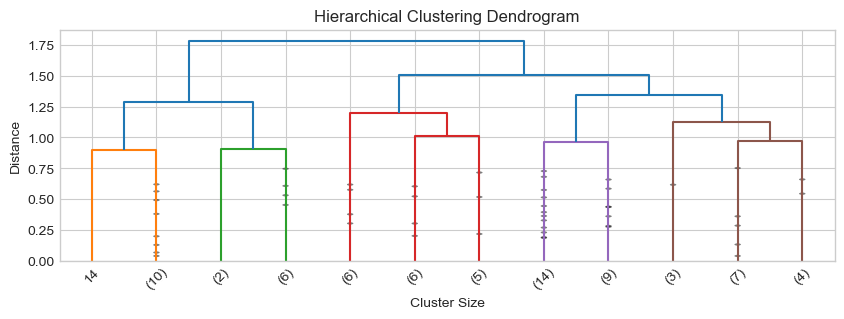

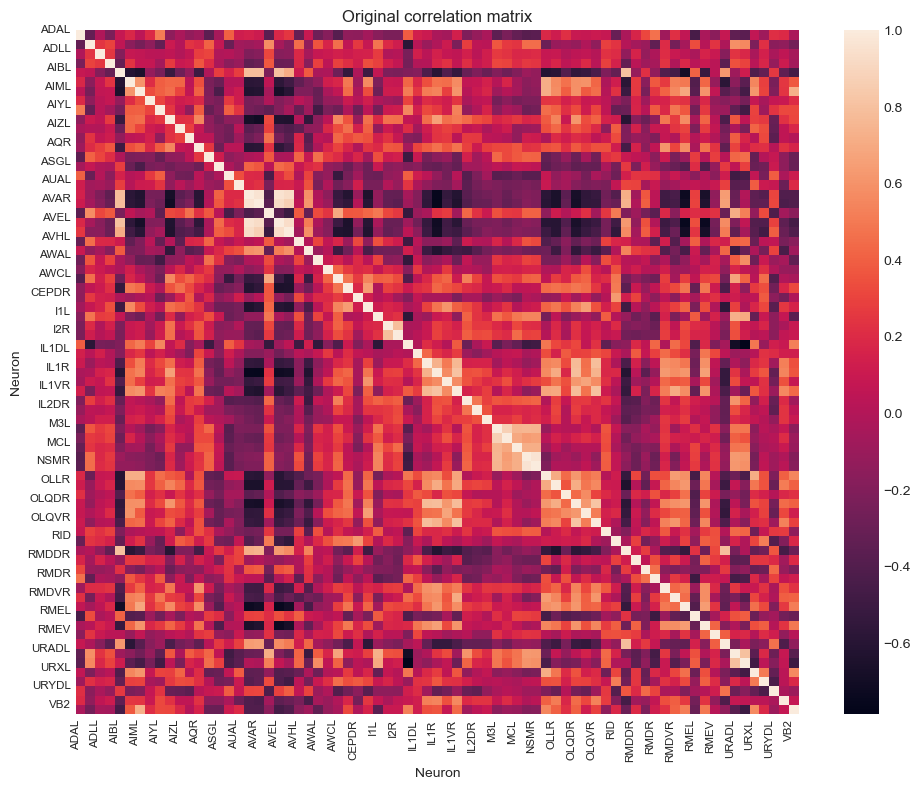

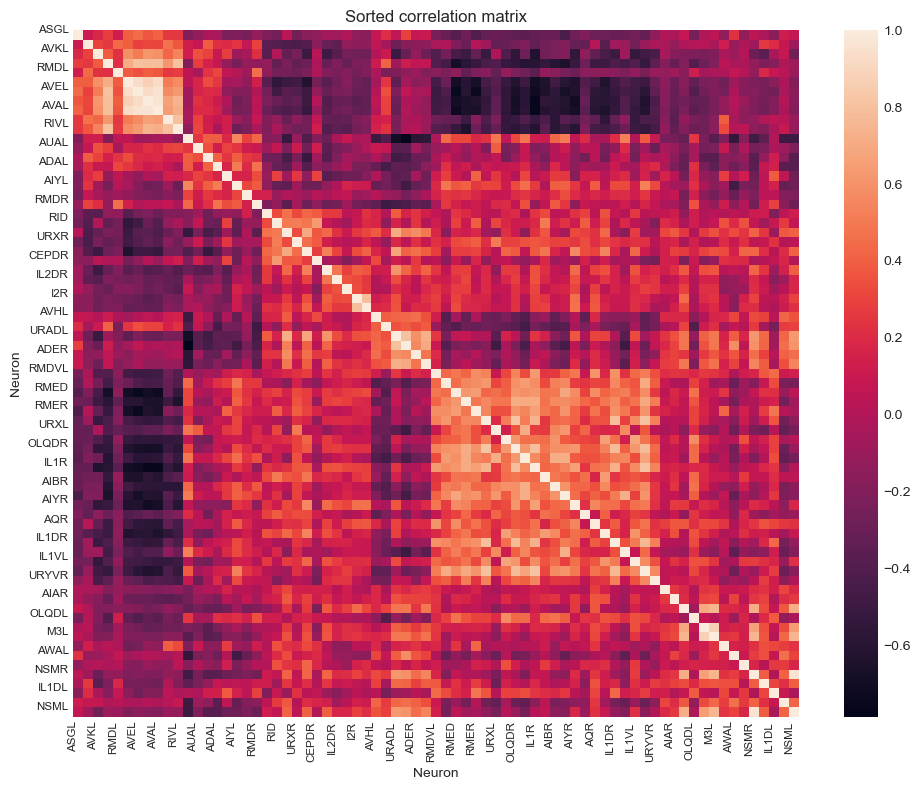

In [35]:
clusters, count_inside_clusters = hierarchical_clustering_analysis(oneWorm, criterion_value=6)

In [36]:
count_inside_clusters

Reference,interneuron,motor,"motor, interneuron",sensory,"sensory, interneuron","sensory, motor","sensory, motor, interneuron"
Computed Cluster,,,,,,,
1,6.0,2.0,1.0,2.0,0.0,0.0,0.0
2,4.0,2.0,0.0,1.0,1.0,0.0,0.0
3,1.0,0.0,1.0,2.0,2.0,0.0,0.0
4,1.0,1.0,0.0,4.0,3.0,2.0,0.0
5,4.0,4.0,0.0,6.0,4.0,1.0,4.0
6,2.0,1.0,0.0,4.0,1.0,5.0,1.0


# PandasAI
---

In [37]:
from pandasai import PandasAI
from pandasai.llm.openai import OpenAI

# Open API_KEY.txt
with open('/home/lrvnc/Projects/worm-graph/tests/leandro/data/API_KEY.txt') as f:
    api_token = f.read().strip()

llm = OpenAI(api_token=api_token)
pandas_ai = PandasAI(llm)

In [41]:
pandas_ai(clusters, prompt="What are the unique values in the column 'Reference'?")

array(['sensory', 'interneuron', 'motor', 'motor, interneuron',
       'sensory, interneuron', 'sensory, motor',
       'sensory, motor, interneuron'], dtype=object)